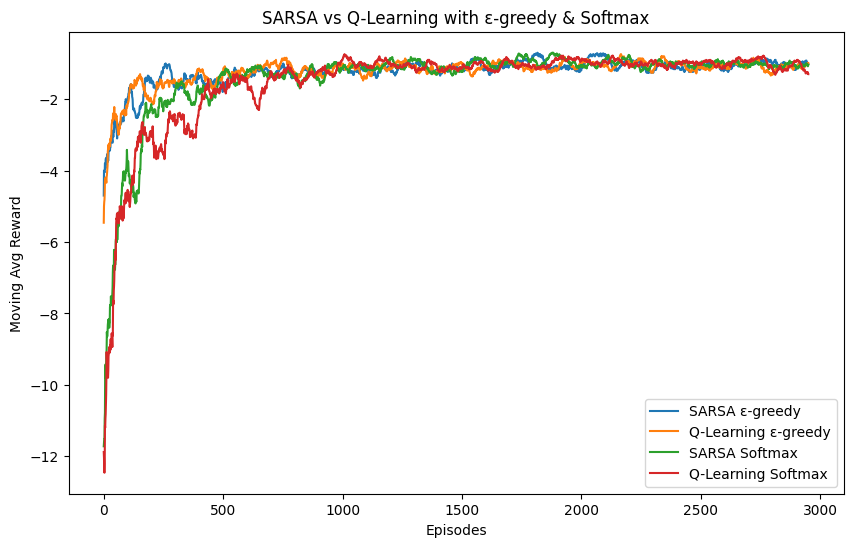


SARSA ε-greedy Policy
T ← ← ↓
↑ ↑ → ↓
↑ → ↓ ↓
↑ → → T

Q-Learning ε-greedy Policy
T ← ← ←
↑ ← ↑ ↓
↑ → ↓ ↓
↑ → → T

SARSA Softmax Policy
T ← ← ↓
↑ ↑ ← ↓
↑ ↓ → ↓
→ → → T

Q-Learning Softmax Policy
T ← ← ←
↑ ← ↓ ↓
↑ → ↓ ↓
↑ → → T


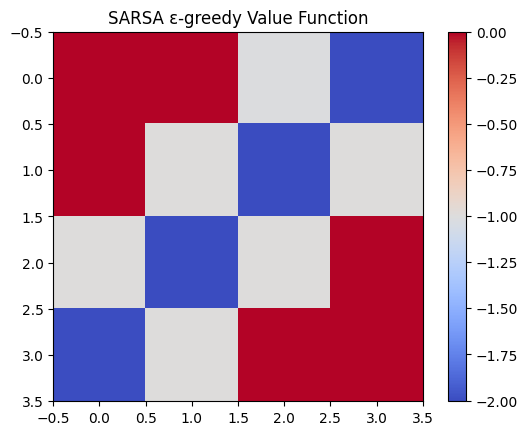

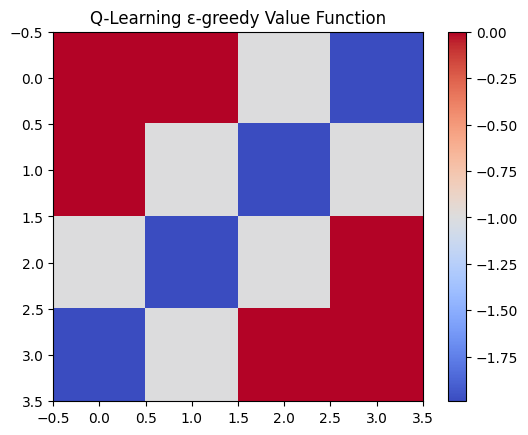

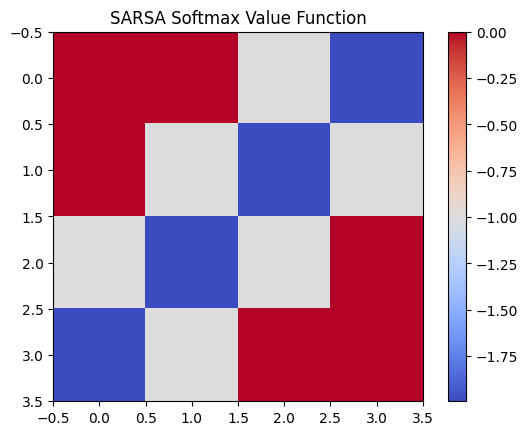

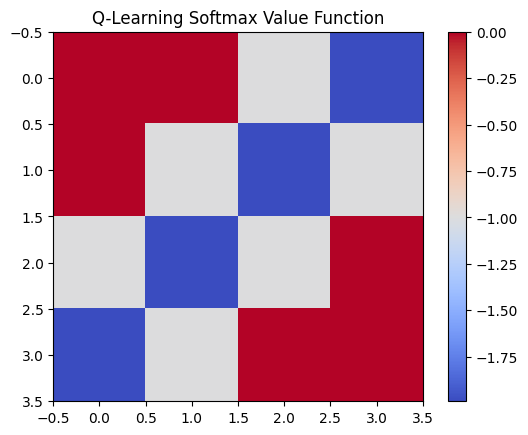

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# ===========================================================
# GRIDWORLD ENVIRONMENT
# ===========================================================
# A simple 4x4 GridWorld:
# - States: positions (row, col)
# - Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
# - Rewards: -1 per step, 0 at terminal states
# - Goal: reach terminal state with maximum cumulative reward
# ===========================================================

class GridWorld:
    def __init__(self, rows=4, cols=4, terminal_states=[(0,0), (3,3)]):
        self.rows = rows
        self.cols = cols
        self.terminal_states = set(terminal_states)
        self.reset()

    def reset(self):
        # Start from a random non-terminal state
        while True:
            r, c = np.random.randint(self.rows), np.random.randint(self.cols)
            if (r,c) not in self.terminal_states:
                self.state = (r,c)
                break
        return self.state

    def step(self, action):
        """Actions: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT"""
        r, c = self.state
        if self.state in self.terminal_states:
            return self.state, 0, True  # episode ends at terminal

        # Move within grid boundaries
        if action == 0:   r = max(r-1, 0)
        elif action == 1: c = min(c+1, self.cols-1)
        elif action == 2: r = min(r+1, self.rows-1)
        elif action == 3: c = max(c-1, 0)

        self.state = (r, c)
        reward = 0 if self.state in self.terminal_states else -1
        done = self.state in self.terminal_states
        return self.state, reward, done

# ===========================================================
# EXPLORATION STRATEGIES
# ===========================================================
# 1. ε-greedy:
#    - With probability ε → choose random action
#    - With probability 1-ε → choose best known action
#    - Balances exploration vs exploitation
#
# 2. Softmax (Boltzmann Exploration):
#    - Converts Q-values into probabilities using temperature τ
#    - High τ → more exploration (uniform distribution)
#    - Low τ → greedy (deterministic)
# ===========================================================

def epsilon_greedy(Q, state, epsilon, nA=4):
    if np.random.rand() < epsilon:
        return np.random.choice(nA)  # explore
    return np.argmax([Q[(state,a)] for a in range(nA)])  # exploit

def softmax(Q, state, tau=1.0, nA=4):
    q_values = np.array([Q[(state,a)] for a in range(nA)])
    prefs = np.exp(q_values / tau)  # convert to preferences
    probs = prefs / np.sum(prefs)   # normalize to probabilities
    return np.random.choice(nA, p=probs)

# ===========================================================
# SARSA (On-policy TD Control)
# ===========================================================
# Update rule:
#   Q(s,a) ← Q(s,a) + α [ r + γ Q(s',a') - Q(s,a) ]
#
# - Uses action a' from policy (on-policy)
# - Learns values of policy it actually follows
# - More conservative, tends to avoid risky actions
# ===========================================================

def sarsa(env, episodes=5000, alpha=0.1, gamma=0.99,
          epsilon=0.1, tau=1.0, strategy="epsilon",
          epsilon_decay=0.999, tau_decay=0.999):
    Q = defaultdict(float)
    rewards = []
    for ep in range(episodes):
        s = env.reset()
        # Choose initial action using exploration strategy
        if strategy=="epsilon":
            a = epsilon_greedy(Q, s, epsilon)
        else:
            a = softmax(Q, s, tau)

        total_reward, done = 0, False
        while not done:
            s_next, r, done = env.step(a)
            total_reward += r

            # Next action (a') chosen from same policy → On-policy
            if strategy=="epsilon":
                a_next = epsilon_greedy(Q, s_next, epsilon)
            else:
                a_next = softmax(Q, s_next, tau)

            # SARSA update
            Q[(s,a)] += alpha * (r + gamma * Q[(s_next,a_next)] - Q[(s,a)])
            s, a = s_next, a_next

        rewards.append(total_reward)

        # Decay exploration parameters over time
        epsilon *= epsilon_decay
        tau *= tau_decay
    return Q, rewards

# ===========================================================
# Q-Learning (Off-policy TD Control)
# ===========================================================
# Update rule:
#   Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') - Q(s,a) ]
#
# - Uses best next action (max) regardless of current policy
# - Off-policy: learns optimal policy while exploring with another
# - More aggressive than SARSA, converges faster but riskier
# ===========================================================

def q_learning(env, episodes=5000, alpha=0.1, gamma=0.99,
               epsilon=0.1, tau=1.0, strategy="epsilon",
               epsilon_decay=0.999, tau_decay=0.999):
    Q = defaultdict(float)
    rewards = []
    for ep in range(episodes):
        s = env.reset()
        total_reward, done = 0, False
        while not done:
            # Choose action from policy (exploration)
            if strategy=="epsilon":
                a = epsilon_greedy(Q, s, epsilon)
            else:
                a = softmax(Q, s, tau)

            s_next, r, done = env.step(a)
            total_reward += r

            # Q-Learning update (max over next actions)
            best_next = max([Q[(s_next,a_)] for a_ in range(4)])
            Q[(s,a)] += alpha * (r + gamma * best_next - Q[(s,a)])
            s = s_next

        rewards.append(total_reward)

        # Decay exploration
        epsilon *= epsilon_decay
        tau *= tau_decay
    return Q, rewards

# ===========================================================
# VISUALIZATION HELPERS
# ===========================================================
# - Reward plots (learning curves)
# - Policy visualization with arrows
# - Value heatmap (state values)
# ===========================================================

def plot_rewards(results, window=50):
    plt.figure(figsize=(10,6))
    for label, rewards in results.items():
        avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(avg, label=label)
    plt.xlabel("Episodes")
    plt.ylabel("Moving Avg Reward")
    plt.title("SARSA vs Q-Learning with ε-greedy & Softmax")
    plt.legend()
    plt.show()

def extract_policy(Q, env):
    actions = ["↑","→","↓","←"]
    policy = np.full((env.rows, env.cols), " ")
    for r in range(env.rows):
        for c in range(env.cols):
            if (r,c) in env.terminal_states:
                policy[r,c] = "T"
            else:
                best_a = np.argmax([Q[((r,c), a)] for a in range(4)])
                policy[r,c] = actions[best_a]
    return policy

def plot_policy(policy, title="Policy"):
    print(f"\n{title}")
    for row in policy:
        print(" ".join(row))

def plot_value(Q, env, title="Value Function"):
    V = np.zeros((env.rows, env.cols))
    for r in range(env.rows):
        for c in range(env.cols):
            V[r,c] = max([Q[((r,c),a)] for a in range(4)])
    plt.imshow(V, cmap="coolwarm", interpolation="nearest")
    plt.colorbar()
    plt.title(title)
    plt.show()

# ===========================================================
# MAIN EXECUTION
# ===========================================================
if __name__ == "__main__":
    env = GridWorld()
    episodes = 3000

    # Train all algorithms with both strategies
    Q_sarsa_eps, R_sarsa_eps = sarsa(env, episodes, strategy="epsilon", epsilon=0.2)
    Q_q_eps, R_q_eps = q_learning(env, episodes, strategy="epsilon", epsilon=0.2)

    Q_sarsa_soft, R_sarsa_soft = sarsa(env, episodes, strategy="softmax", tau=1.0)
    Q_q_soft, R_q_soft = q_learning(env, episodes, strategy="softmax", tau=1.0)

    # Compare rewards
    results = {
        "SARSA ε-greedy": R_sarsa_eps,
        "Q-Learning ε-greedy": R_q_eps,
        "SARSA Softmax": R_sarsa_soft,
        "Q-Learning Softmax": R_q_soft
    }
    plot_rewards(results)

    # Show policies
    plot_policy(extract_policy(Q_sarsa_eps, env), "SARSA ε-greedy Policy")
    plot_policy(extract_policy(Q_q_eps, env), "Q-Learning ε-greedy Policy")
    plot_policy(extract_policy(Q_sarsa_soft, env), "SARSA Softmax Policy")
    plot_policy(extract_policy(Q_q_soft, env), "Q-Learning Softmax Policy")

    # Show value functions
    plot_value(Q_sarsa_eps, env, "SARSA ε-greedy Value Function")
    plot_value(Q_q_eps, env, "Q-Learning ε-greedy Value Function")
    plot_value(Q_sarsa_soft, env, "SARSA Softmax Value Function")
    plot_value(Q_q_soft, env, "Q-Learning Softmax Value Function")
